# Multi-annotator Pool-based Active Learning - Getting Started

This notebook gives an introduction for dealing with multiple annotators using `skactiveml`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs

from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import ProbabilisticAL
from skactiveml.pool.multi import SingleAnnotWrapper
from skactiveml.utils import MISSING_LABEL, majority_vote
from skactiveml.visualization.multi import (
    plot_ma_current_state,
    plot_ma_data_set,
)

FONTSIZE = 20
MARKER_SIZE = 100

Suppose we have the following problem. We have 100 samples with 2 features and belonging to one of two classes. To generate the example problem, we use the `make_blobs` function by `sklearn`.

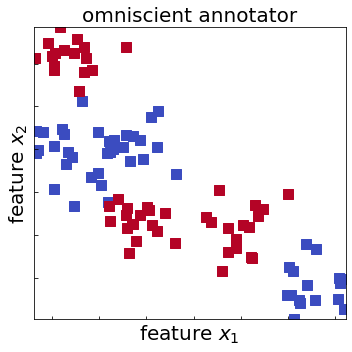

In [2]:
n_samples = 100
X, y_true = make_blobs(
    n_samples=n_samples, centers=6, random_state=0
)
y_true %= 2
fig = plot_ma_data_set(
    X,
    y_true.reshape(-1, 1),
    y_true,
    fig_size=(5, 5),
    plot_legend=False,
    fontsize=FONTSIZE,
    marker_size=MARKER_SIZE,
)
fig.axes[0].set_title("omniscient annotator", fontsize=FONTSIZE)
fig.tight_layout()
plt.show()

Further, suppose we have 5 annotators to label the samples. The annotators have different accuracies for labeling the samples.

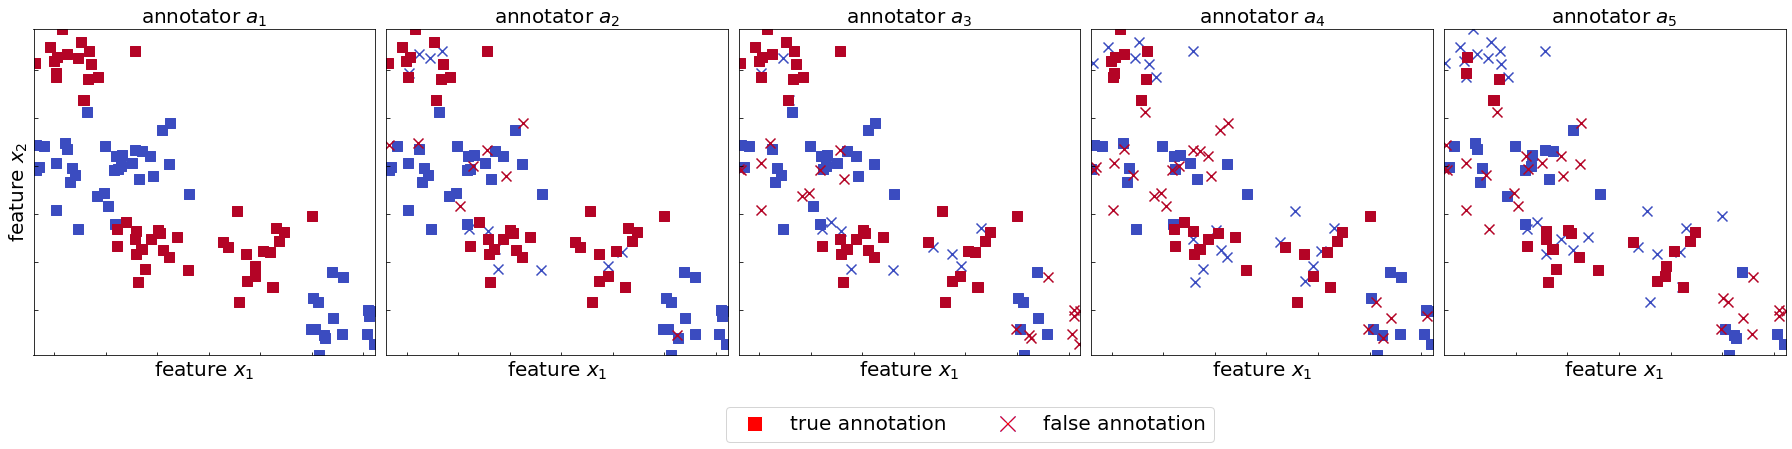

In [3]:
rng = np.random.default_rng(seed=0)
n_annotators = 5
y_annot = np.zeros(shape=(n_samples, n_annotators), dtype=int)
for i, p in enumerate(np.linspace(0.0, 0.5, num=n_annotators)):
    y_noise = rng.binomial(1, p, n_samples)
    y_annot[:, i] = y_noise ^ y_true

fig = plot_ma_data_set(
    X,
    y_annot,
    y_true,
    fig_size=(25, 5.5),
    legend_dict={"bbox_to_anchor": [0.4, -0.15], "ncol": 2},
    fontsize=FONTSIZE,
    marker_size=MARKER_SIZE,
)
fig.tight_layout()
plt.show()

We want to label these samples using a Parzen window classifier. We query the samples using uncertainty sampling, and the annotators at random using the
`SingleAnnotWrapper`. To achieve this, we first pass the Parzen window classifier as an argument to the single annotator query strategy `ProbabilisticAL`.
Then we pass the single annotator query strategy as an argument to the wrapper, also specifying the number of annotators.


In [4]:
clf = ParzenWindowClassifier(
    classes=np.unique(y_true),
    metric="rbf",
    metric_dict={"gamma": 0.1},
    class_prior=0.001,
    random_state=0,
)
sa_qs = ProbabilisticAL(random_state=0, prior=0.001)
ma_qs = SingleAnnotWrapper(sa_qs, random_state=0)

We loop through the process of querying samples and annotators over a total of 20 cycles. Each iteration, we query three annotators for one sample, setting the
batch size and the number of annotators per sample to three. We set the candidate annotators for each sample to be those, who have not already labeled the given sample.
Further we fit our classifier using the majority votes of the queried labels. The results are displayed after the 5th, the 14th, and the 20th cycle.
The assigned utilities of the query strategy for labeling a sample annotator pair are displayed by the saturation of the green color in the plot.


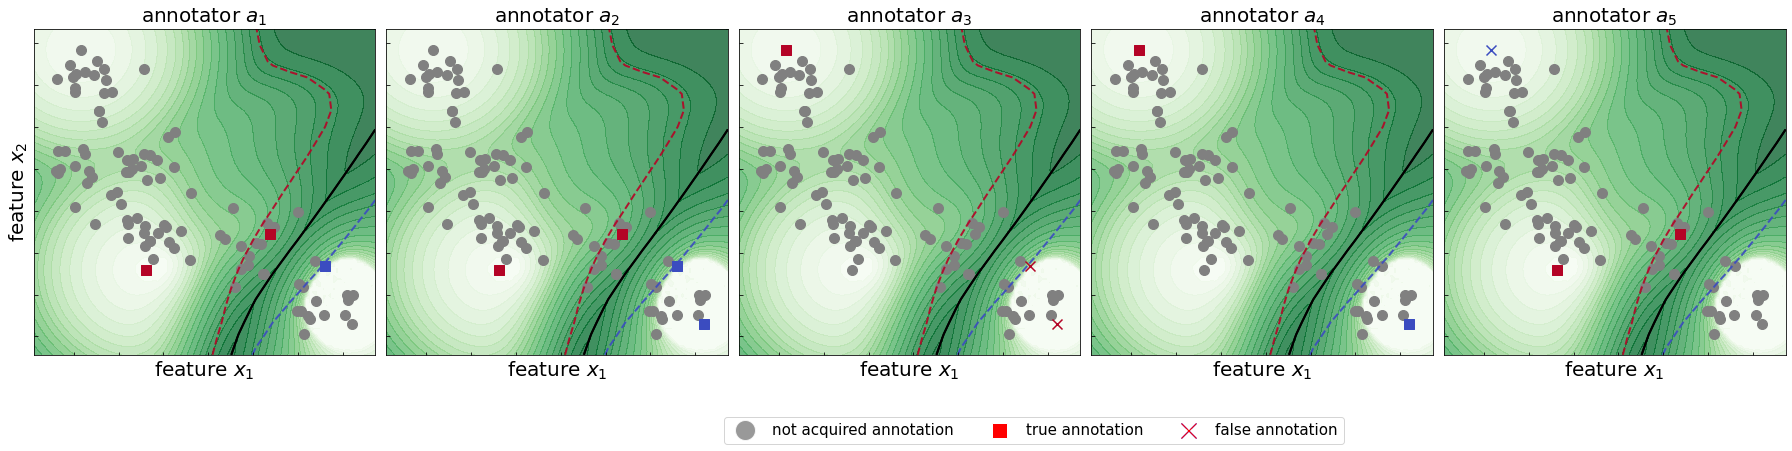

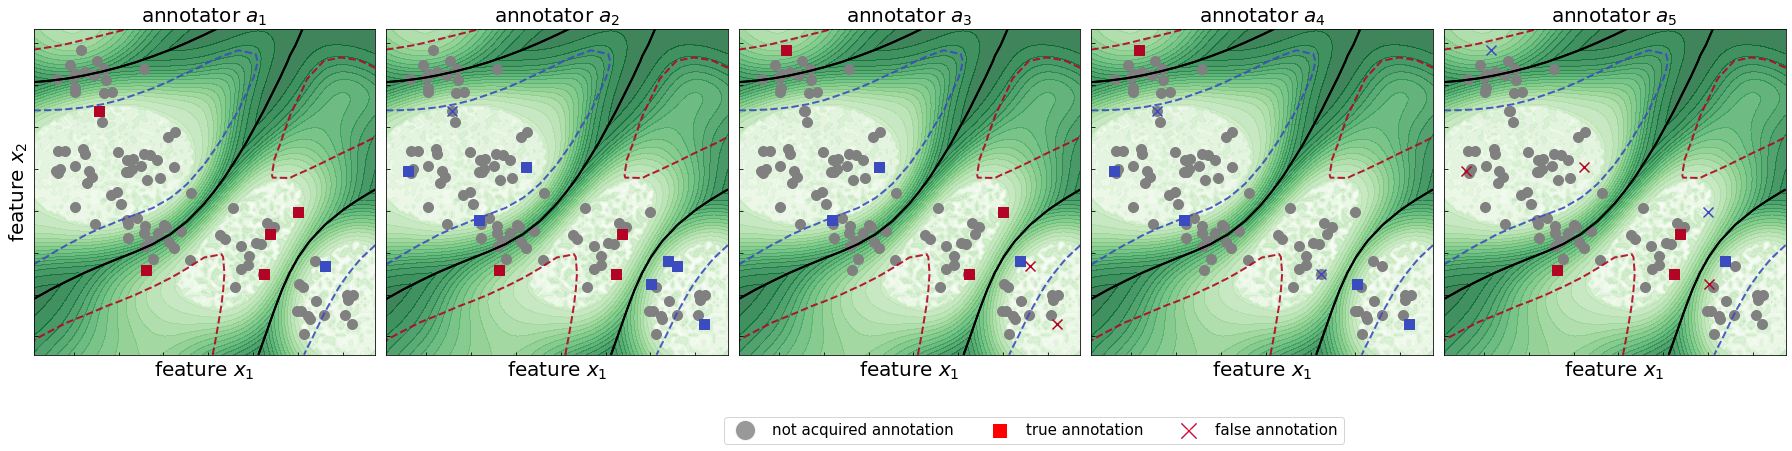

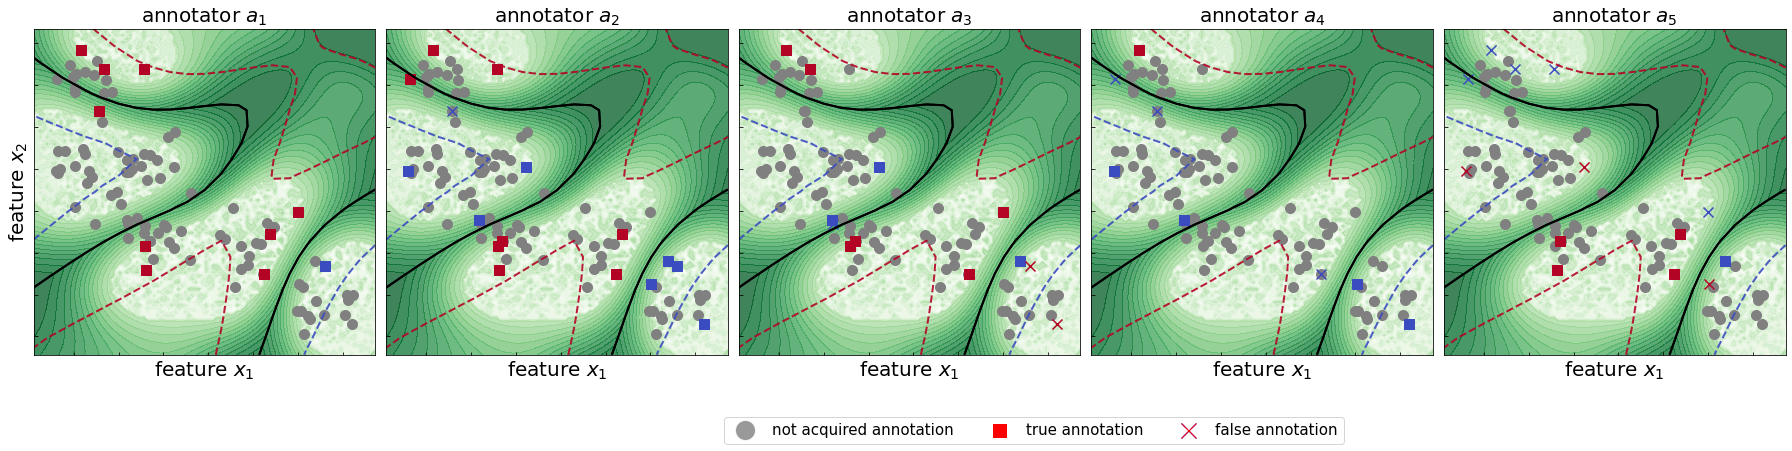

In [5]:
# function to be able to index via an array of indices
idx = lambda A: (A[:, 0], A[:, 1])

n_cycle = 20

# the already observed labels for each sample and annotator
y = np.full(shape=(n_samples, n_annotators), fill_value=MISSING_LABEL)
clf.fit(X, majority_vote(y))
for c in range(n_cycle):
    # the needed query parameters for the wrapped single annotator query strategy
    query_params_dict = {"clf": clf}

    query_idx = ma_qs.query(
        X,
        y,
        batch_size=3,
        n_annotators_per_sample=3,
        query_params_dict=query_params_dict,
    )

    y[idx(query_idx)] = y_annot[idx(query_idx)]
    clf.fit(X, majority_vote(y, random_state=0))
    if c in [4, 13, 19]:
        ma_qs_arg_dict = {"query_params_dict": query_params_dict}
        fig = plot_ma_current_state(
            X,
            y,
            y_true,
            ma_qs,
            clf,
            epsilon=1,
            ma_qs_arg_dict=ma_qs_arg_dict,
            fig_size=(25, 5.5),
            legend_dict={"bbox_to_anchor": [0.4, -0.15], "ncol": 3},
            fontsize=FONTSIZE,
            marker_size=MARKER_SIZE,
            res=100,
            contour_dict={"levels": 20},
        )
        fig.tight_layout()
        plt.show()